# Hiru gorputzeko problemaren soluzio periodikoen bilaketa, fasez fase

<ul id="top">
<li><a href="#Pakete-eta-funtzioak-kargatu"> 
    Pakete eta funtzioak kargatu</a></li>
<li><a href="#1.-Fasea:-Ausazko-hasierako-egoera-lortu">
    1. Fasea: Ausazko hasierako egoera lortu</a></li>
<li><a href="#2.-Fasea:-$z$-taulako-$z_3$-eta-$z_4$-osagaiak-optimizatu">
    2. Fasea: $z$ taulako $z_3$ eta $z_4$ osagaiak optimizatu</a></li>
<li><a href="#3.-Fasea:-$z$-taula-osoa-optimizatu">
    3. Fasea: $z$ taula osoa optimizatu</a></li>
<li><a href="#4.-Fasea:-soluzio-periodikoaren-periodoa,-$T$-optimizatu-$z$-taularekin-batera">
    4. Fasea: soluzio periodikoaren periodoa, $T$ optimizatu $z$ taularekin batera</a></li>
<li><a href="#5.-Fasea:-Sistemaren-energia,-$h$,-moldatu-$T$-eta-$z$-taularekin-batera">
    5. Fasea: Sistemaren energia, $h$, moldatu $T$ eta $z$ taularekin batera</a></li>
<li><a href="#Une-kolinealak-aztertu">
    Une kolinealak aztertu</a></li>
<li><a href="#Fast-Fourier-Transform">
    Fast Fourier Transform</a></li>
<li><a href="#Minimo-lokal-batean-al-gaude?">
    Minimo lokal batean al gaude?</a></li>   
</ul>  

## Pakete eta funtzioak kargatu

In [15]:
using LinearAlgebra
using Plots 
using Optim
using BenchmarkTools
using Combinatorics
using CSV
using DataFrames
using ForwardDiff
using FFTW

In [26]:
include("./src/EMI.jl"); include("./src/TBP.jl"); include("./src/utils.jl"); include("./src/Loss.jl");

<a href="#top">Hasierara</a>
## 1. Fasea: Ausazko hasierako egoera lortu

In [21]:
z0 = pi*rand(4)
u0 = HasierakoEgoera(z0)
U0 = LCinvFcn(u0)
h = ThreeBodyRelEnergy(u0)
kont = 1
while (E_bitarra(U0, rel2abs(u0))>0 || TBP_Bitarra(U0, 1/256, 50., h))
    z0 = pi*rand(4)
    u0 = HasierakoEgoera(z0)
    U0 = LCinvFcn(u0)
    kont+=1
    println(kont)
end

In [22]:
@time u0 = HasierakoEgoera(z0)
U0 = LCinvFcn(u0)
println([ThreeBodyHamiltonianLC(U0), -ThreeBodyRelPotential(u0), ThreeBodyRelEnergy(u0)])
println([AngularMomentum(rel2abs(u0)),g(U0)])

  0.000007 seconds (2 allocations: 160 bytes)
[0.0, 0.7029152028753978, -0.5]
[1.1102230246251565e-16, 0.0]


### Parametroak definitu

In [38]:
tauend = 20.
h = ThreeBodyRelEnergy(u0)
par = h
dtau = 1/256

0.00390625

### Erdiguneko metodo inplizituaren soluzioaren irudikapena
Erdiguneko metodo inplizitua erabiliz, dtau luzerako urrats bakoitzean problemaren egoera bildu eta grafiko batean erakusten du.

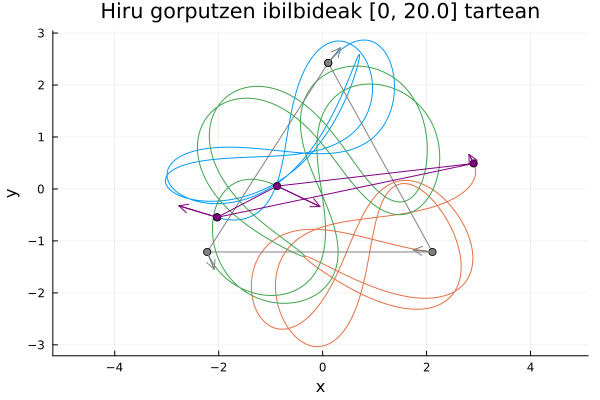

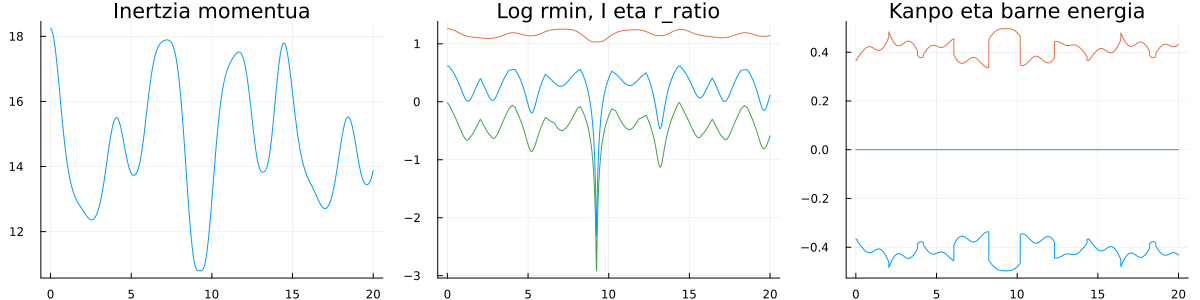

In [39]:
tt, UU, uu = Irudikatu(z0, 0., tauend, dtau, par)
IrudikatuIELog(tt, UU,uu)

### Energia errore eta errore hamiltondarrak

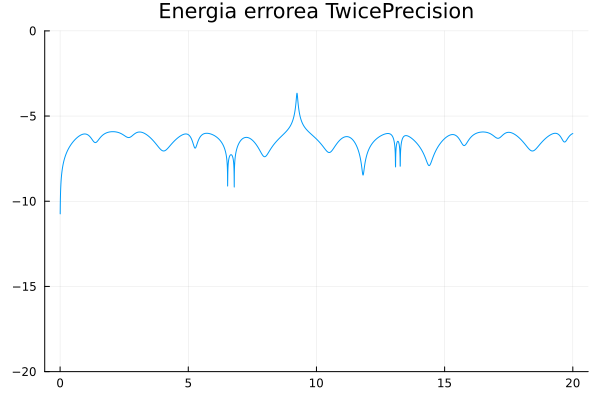

In [40]:
yrange = (-20, 0)
energia_erroreakTP = [ThreeBodyRelEnergy(u)/h - 1  for u in uu]
energia_errore_lokalakTP = energia_erroreakTP[2:end]-energia_erroreakTP[1:end-1]

pl1 = plot(tt, log10.(abs.(energia_erroreakTP)), legend = false,  title = "Energia errorea TwicePrecision", ylims=yrange)

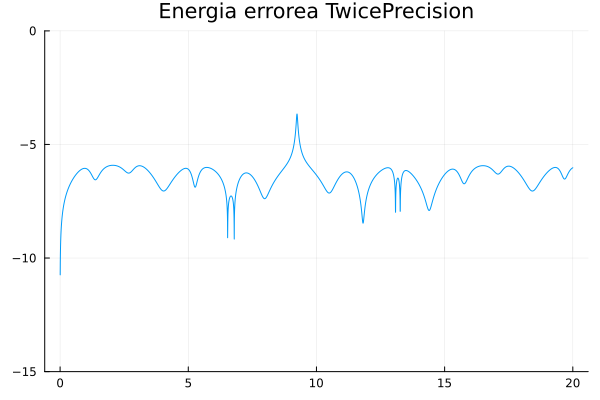

In [41]:
yrange = (-15, 0)
energia_erroreakTP = [ThreeBodyRelEnergy(u)/h - 1  for u in uu]
energia_errore_lokalakTP = energia_erroreakTP[2:end]-energia_erroreakTP[1:end-1]

pl1 = plot(tt, log10.(abs.(energia_erroreakTP)), legend = false,  title = "Energia errorea TwicePrecision", ylims=yrange)

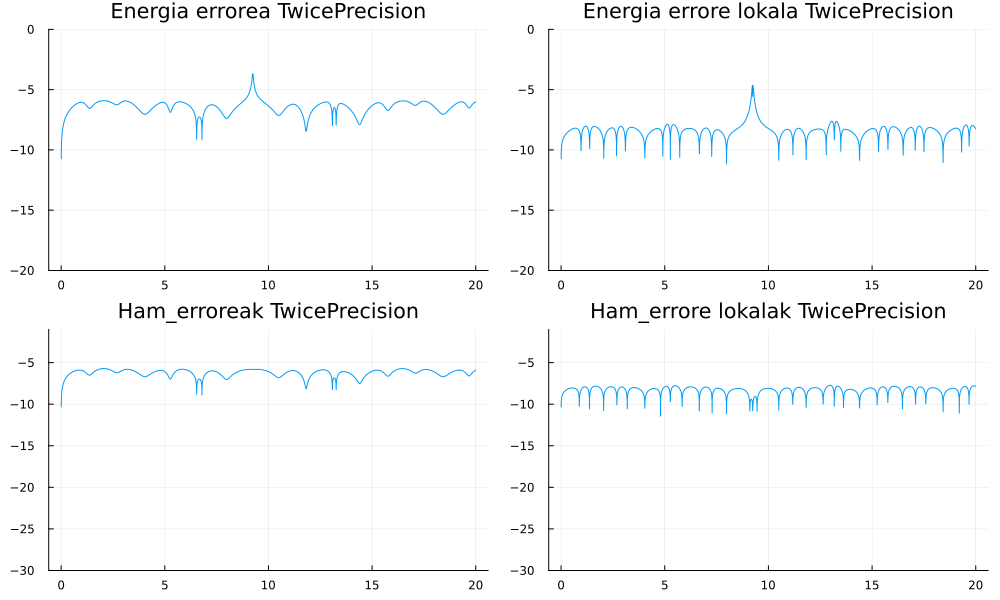

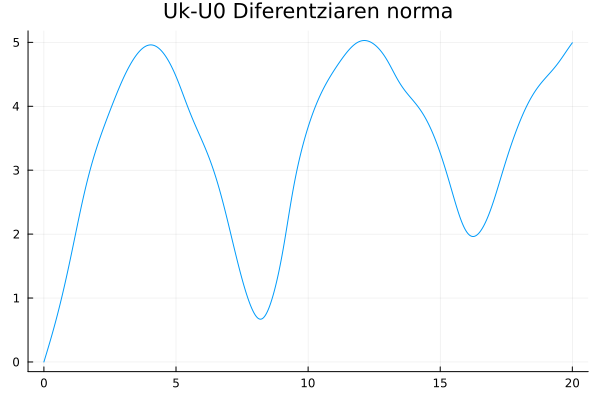

In [42]:
IrudikatuErrEH(tt, UU, uu)
IrudikatuRet(tt, UU)

<a href="#top">Hasierara</a>
## 2. Fasea: $z$ taulako $z_3$ eta $z_4$ osagaiak optimizatu

In [43]:
z = copy(z0)
F0 = FLoss0(z,dtau,tauend,h)
w0 = [z[3], z[4]]
helb_minn,ss = F0(w0,3)
@time T, sigma = F0(w0, 2)
(helb_minn, T, sigma)

  0.005953 seconds (77.45 k allocations: 2.288 MiB)


(2.1629991985561716, 14.45703125, (1, 3, 2))

In [44]:
@time res0 = optimize(F0,w0)

  0.793423 seconds (7.37 M allocations: 217.719 MiB, 25.51% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     3.313388e-03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    45
    f(x) calls:    95


In [45]:
w1 = Normalizatu_z(res0.minimizer)
helb_minn, ss = F0(w1, 3);
T, sigma = F0(w1, 2)

(helb_minn, T, sigma)

(0.0033133882498256537, 14.3828125, (1, 3, 2))

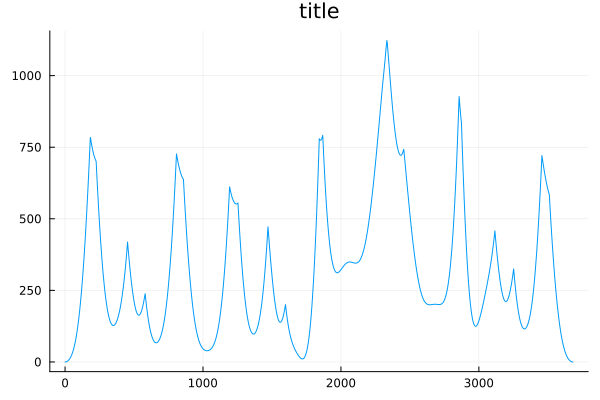

In [46]:
pl = plot([0:T/F0.dtau], ss[1:Int64(T/F0.dtau)+1], title="title", legend = false)

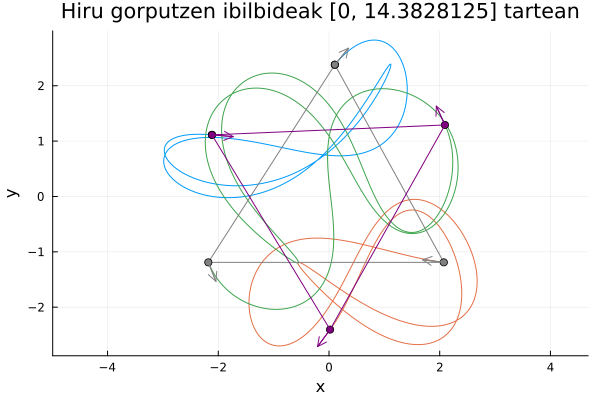

In [47]:
z1 = copy(F0.z)
z1[3:4] .= w1
tt,UU,uu = Irudikatu(z1, 0., T, F0.dtau, F0.h);

<a href="#top">Hasierara</a>
## 3. Fasea: $z$ taula osoa optimizatu

In [48]:
F1 = FLoss1(dtau,tauend,h)
helb_minn,ss = F1(z1,3)
@time T, sigma = F1(z1, 2)
(helb_minn, T, sigma)

  0.006058 seconds (77.42 k allocations: 2.287 MiB)


(0.0033133882498256537, 14.3828125, (1, 3, 2))

In [49]:
@time res1 = optimize(F1,z1)

  4.300604 seconds (52.51 M allocations: 1.515 GiB, 4.13% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     8.542178e-05

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    385
    f(x) calls:    678


In [50]:
z1_opt = Normalizatu_z(res1.minimizer)
helb_minn,ss = F1(z1_opt,3)
@time T, sigma = F1(z1_opt, 2)
(helb_minn, T, sigma)

  0.005781 seconds (77.40 k allocations: 2.286 MiB)


(8.542178028572525e-5, 14.3828125, (1, 3, 2))

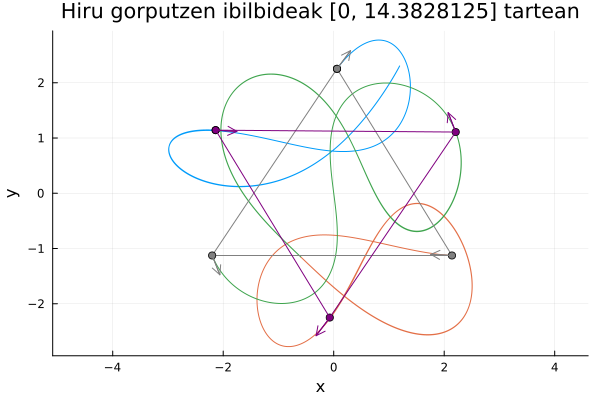

In [51]:
tt, UU, uu = Irudikatu(z1_opt, 0., T, F0.dtau, F0.h);

<a href="#top">Hasierara</a>
## 4. Fasea: soluzio periodikoaren periodoa, $T$ optimizatu $z$ taularekin batera

In [52]:
Z0 = copy(z1_opt)
push!(Z0, T)
F2 = FLoss2(sigma,Int64(ceil(Z0[5]/F1.dtau)),F1.h)
@time F2(Z0)

  0.290632 seconds (198.68 k allocations: 9.646 MiB, 99.41% compilation time)


8.542178028572525e-5

In [53]:
@time res2 = optimize(F2, Z0, g_tol=1e-13, autodiff=:forward, method=BFGS())

  5.292346 seconds (7.84 M allocations: 392.769 MiB, 1.35% gc time, 87.55% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     4.794302e-27

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.72e-12 ≰ 1.0e-13

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    18
    f(x) calls:    86
    ∇f(x) calls:   86


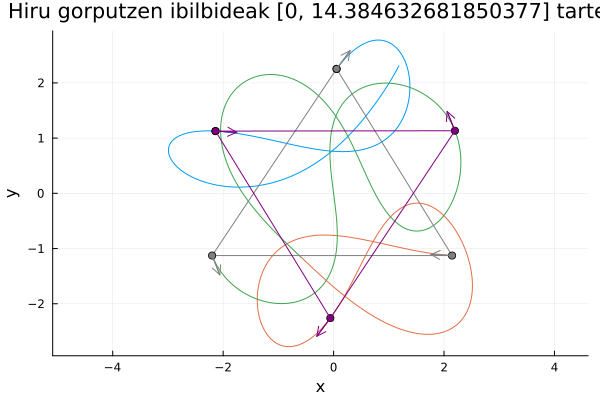

In [54]:
Zopt2 = Normalizatu_z(res2.minimizer)
tt, UU,uu = Irudikatu(Zopt2,0.,Zopt2[5], Zopt2[5]/F2.nsteps, F1.h);

<a href="#top">Hasierara</a>
## 5. Fasea: Sistemaren energia, $h$, moldatu $T$ eta $z$ taularekin batera

In [55]:
W0= copy(Zopt2)
push!(W0, -0.5)
#W0= copy(z1_opt)
#push!(W0, T)
#push!(W0, -0.5)
F3 = FLoss3(sigma,Int64(ceil(W0[5]/F1.dtau)))
@time F3(W0)

  0.048657 seconds (41.18 k allocations: 1.985 MiB, 96.67% compilation time)


4.507991434970596e-14

In [56]:
@time res3 = optimize(F3, W0, g_tol=1e-13, autodiff=:forward, method=BFGS())

  2.745051 seconds (2.90 M allocations: 141.760 MiB, 0.72% gc time, 70.08% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     5.387920e-28

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.24e-12 ≰ 1.0e-13

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    12
    f(x) calls:    72
    ∇f(x) calls:   72


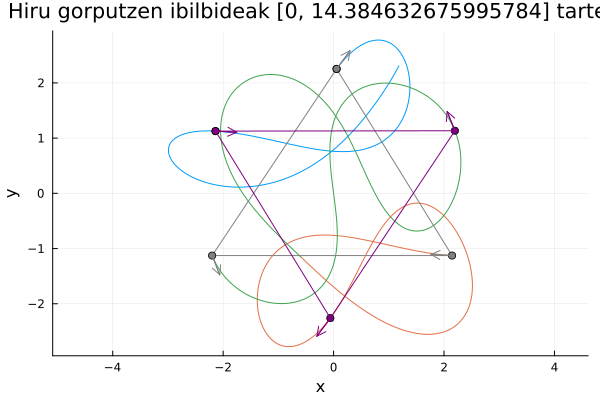

Kodea_far: [1, 2, 2, 1, 1, 2, 2, 1, 1]
Kodea_middle: [2, 3, 1, 2, 3, 1, 1, 3, 2]


In [58]:
Zopt3 = Normalizatu_z(res3.minimizer)
tt, UU, uu = Irudikatu(Zopt3,0.,Zopt3[5], Zopt3[5]/F2.nsteps, Zopt3[6]);
g_col_list = [g_col(u) for u in uu]
code_middle, code_far, ind_kolinear_list = getCode(UU, g_col_list)
println("Kodea_far: ", code_far)
println("Kodea_middle: ", code_middle)

<a href="#top">Hasierara</a>
## Une kolinealak aztertu

In [59]:
i = 0;

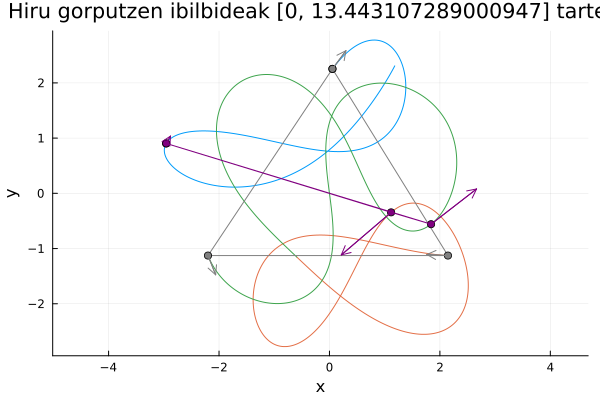

In [68]:
i+=1
Irudikatu(Zopt3,0.,tt[ind_kolinear_list[i]], Zopt3[5]/F2.nsteps, Zopt3[6]); 

<a href="#top">Hasierara</a>
## Fast Fourier Transform

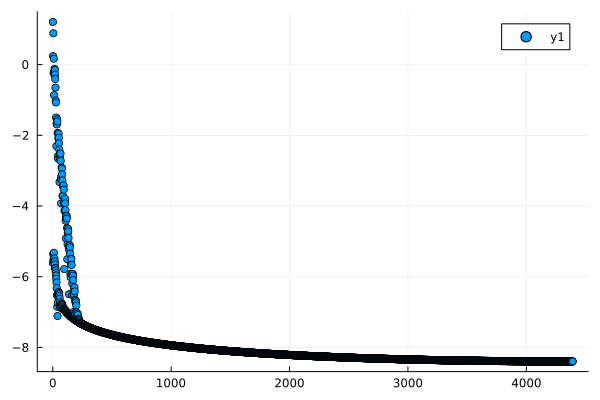

In [777]:
II = I_fcn.(UU[1:end-1])
hII = rfft(II)/length(II)
loghII = log10.(abs.(hII))
scatter(loghII)

<a href="#top">Hasierara</a>
## Minimo lokal batean al gaude?

In [778]:
helb = F3(BigFloat.(Zopt3))

1.906386056722817865204969858884508249878852340502703379792329902613529883512834e-20

In [779]:
gradF3 = ForwardDiff.gradient(F3,BigFloat.(Zopt3))

6-element Vector{BigFloat}:
 -4.381715262806766327559816526642726623250912519756341861532945704662928858831143e-08
 -7.440014632832076822369375267363683879769602474377972219008695934667591710377852e-14
 -4.728196099466554532832396034823031351801300552355151334473155153456219490208449e-08
  2.039642381799252735565852826180897972913362799809761793096902803576062642819084e-09
  7.663117466600357744602518998154754097803050440866552043142183080758757648978621e-10
  6.905716296154868350755056148399292019925467141773581417566702262355883993698949e-08

In [780]:
hess = ForwardDiff.hessian(F3,Zopt3)

eigen(hess).values

6-element Vector{Float64}:
      1.6939605274046698e-9
      3.1800336727744583e-9
     14.26897097116823
 132829.91102734522
      7.797557584861463e6
      4.900258847254172e7

In [ ]:
Z3 = Zopt3 - hess\gradF3

In [ ]:
Float64.(ForwardDiff.gradient(F3,BigFloat.(Z3)))

In [ ]:
Z3 = Float64.(Z3)

In [ ]:
(Float64.(F3(BigFloat.(Z3))), Float64.(F3(BigFloat.(Zopt3))))

In [ ]:
tt, UU = Irudikatu(Zopt3,0.,Zopt3[5], Zopt3[5]/F3.nsteps, Zopt3[6]);

In [ ]:
IrudikatuIDeribatuak(tt, UU, LCFcn.(UU))